In [1]:
import numpy as np
import scipy.stats as stats
import scipy.spatial.distance as dist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import wasserstein_distance, ks_2samp, mannwhitneyu, entropy, levene, normaltest
from sklearn.manifold import MDS
import pandas as pd
import glob
import tqdm 

### DATA

In [2]:
# Trova tutti i file CSV che iniziano con 'bnabs' (per diseased)
diseased_files = glob.glob("./cincinnati_repertoires/bnabs*.csv")

# Trova tutti i file CSV che iniziano con 'healthy' (per healthy)
healthy_files = glob.glob("./cincinnati_repertoires/healthy*.csv")

# Lista per memorizzare i dati di perplexity
diseased = []
healthy = []

# Leggere i file 'diseased' e aggiungere la colonna 'perplexity' alla lista
for file in diseased_files:
    df = pd.read_csv(file)
    if 'perplexity' in df.columns:
        diseased.append(df['perplexity'].values)

# Leggere i file 'healthy' e aggiungere la colonna 'perplexity' alla lista
for file in healthy_files:
    df = pd.read_csv(file)
    if 'perplexity' in df.columns:
        healthy.append(df['perplexity'].values)

diseased = diseased
healthy = healthy
n_healthy = len(healthy)
print('# healthy patients',n_healthy) #42
n_diseased = len(diseased)
print('# diseased patients',n_diseased) #46

# healthy patients 42
# diseased patients 46


# DIMENSIONALITY REDUCTION

Shape of X: (88, 30), Shape of y: (88,)


/home/rodelc/anaconda3/envs/aa_ss_tokenizer_2.0/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/rodelc/anaconda3/envs/aa_ss_tokenizer_2.0/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


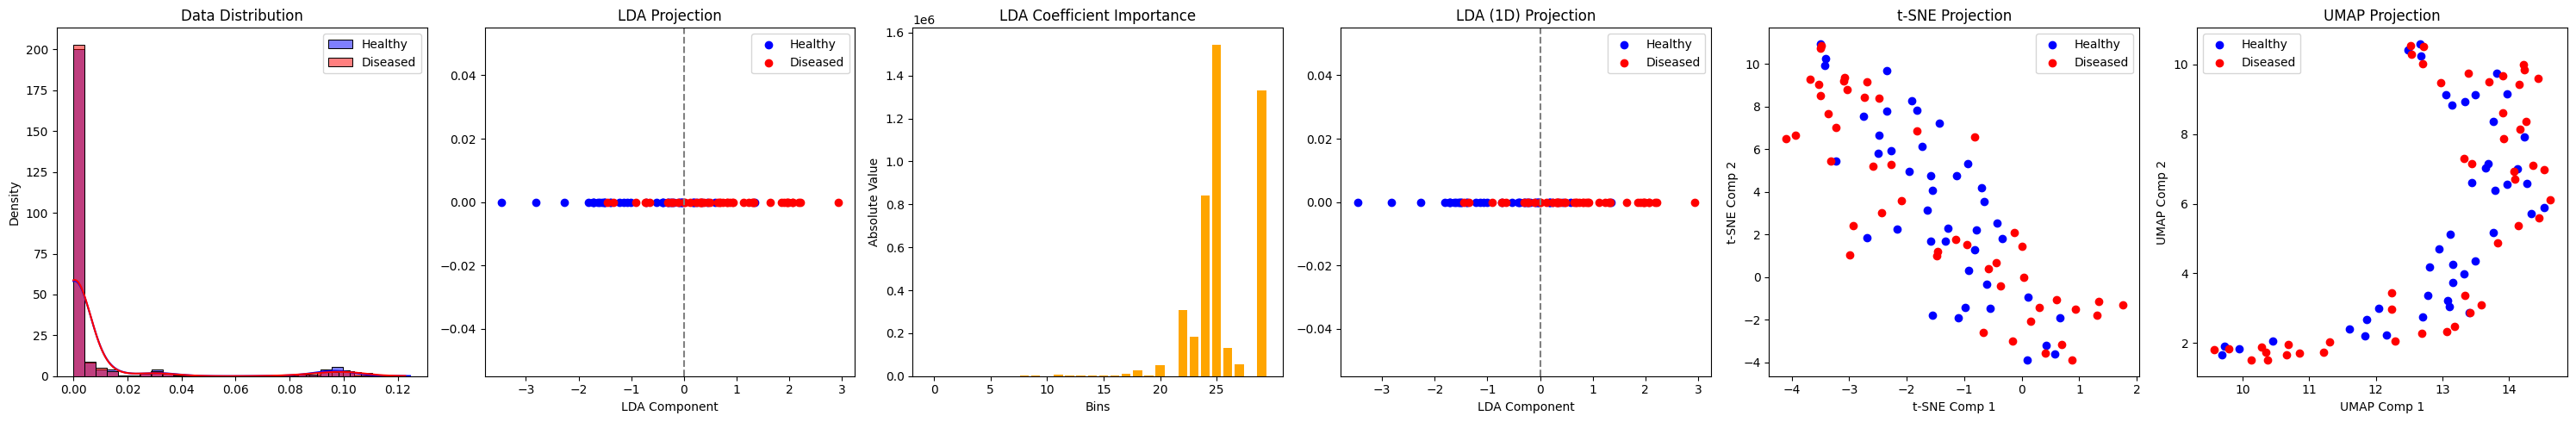

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Elaborazione dati: conversione in istogrammi
bins = 30
hist_range = (0, 120)
X_healthy = np.array([np.histogram(p, bins=bins, range=hist_range, density=True)[0] for p in healthy])
X_diseased = np.array([np.histogram(p, bins=bins, range=hist_range, density=True)[0] for p in diseased])

X = np.vstack([X_healthy, X_diseased])
y = np.array([0] * len(X_healthy) + [1] * len(X_diseased))
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

# Calcolo LDA
lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X, y)
lda_coefficients = lda.coef_[0]

# Calcolo t-SNE e UMAP
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

# Creazione della figura con 1 riga e 6 colonne
fig, axes = plt.subplots(1, 6, figsize=(30, 5))

# 1. Distribuzione dei dati (istogrammi)
sns.histplot(X_healthy.flatten(), bins=30, color="blue", label="Healthy", kde=True, stat="density", ax=axes[0])
sns.histplot(X_diseased.flatten(), bins=30, color="red", label="Diseased", kde=True, stat="density", ax=axes[0])
axes[0].legend()
axes[0].set_title("Data Distribution")

# 2. LDA Projection (1D)
axes[1].scatter(X_lda[y == 0], np.zeros_like(X_lda[y == 0]), color="blue", label="Healthy")
axes[1].scatter(X_lda[y == 1], np.zeros_like(X_lda[y == 1]), color="red", label="Diseased")
axes[1].axvline(0, linestyle="dashed", color="gray")
axes[1].legend()
axes[1].set_title("LDA Projection")
axes[1].set_xlabel("LDA Component")

# 3. Bar plot dei coefficienti LDA
axes[2].bar(range(bins), np.abs(lda_coefficients), color='orange')
axes[2].set_title('LDA Coefficient Importance')
axes[2].set_xlabel('Bins')
axes[2].set_ylabel('Absolute Value')
axes[2].set_xticks(range(0, bins, 5))

# 4. (Ancora) LDA Projection (per completezza, se vuoi ripeterla)
axes[3].scatter(X_lda[y == 0], np.zeros_like(X_lda[y == 0]), color="blue", label="Healthy")
axes[3].scatter(X_lda[y == 1], np.zeros_like(X_lda[y == 1]), color="red", label="Diseased")
axes[3].axvline(0, linestyle="dashed", color="gray")
axes[3].legend()
axes[3].set_title("LDA (1D) Projection")
axes[3].set_xlabel("LDA Component")

# 5. t-SNE Projection (2D)
axes[4].scatter(X_tsne[y == 0, 0], X_tsne[y == 0, 1], color="blue", label="Healthy")
axes[4].scatter(X_tsne[y == 1, 0], X_tsne[y == 1, 1], color="red", label="Diseased")
axes[4].legend()
axes[4].set_title("t-SNE Projection")
axes[4].set_xlabel("t-SNE Comp 1")
axes[4].set_ylabel("t-SNE Comp 2")

# 6. UMAP Projection (2D)
axes[5].scatter(X_umap[y == 0, 0], X_umap[y == 0, 1], color="blue", label="Healthy")
axes[5].scatter(X_umap[y == 1, 0], X_umap[y == 1, 1], color="red", label="Diseased")
axes[5].legend()
axes[5].set_title("UMAP Projection")
axes[5].set_xlabel("UMAP Comp 1")
axes[5].set_ylabel("UMAP Comp 2")

plt.tight_layout()
plt.show()


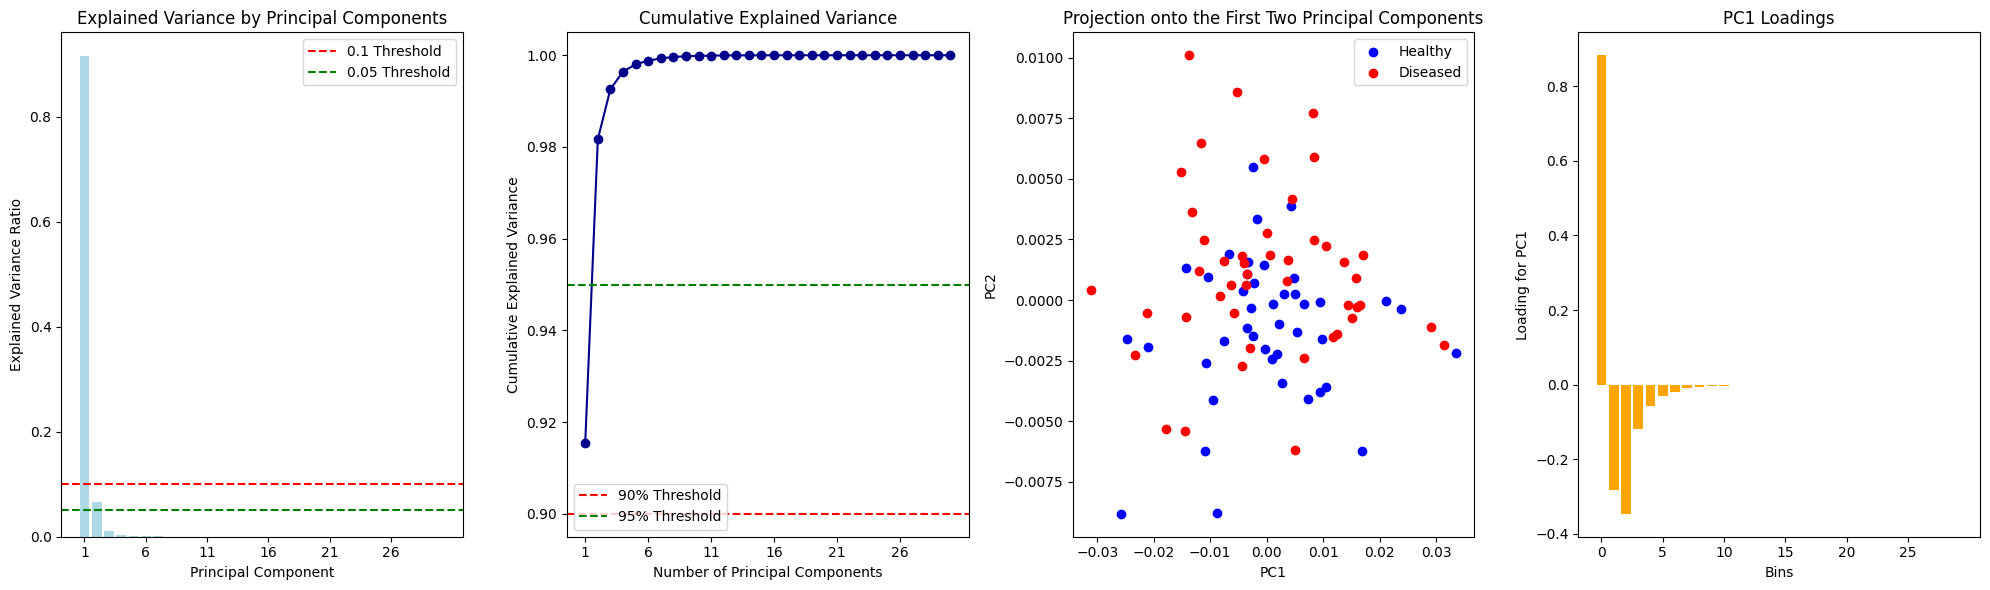

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Apply PCA
pca = PCA(n_components=bins)  # Keep all components (up to the number of bins)
X_pca = pca.fit_transform(X)

# Plot all the graphs in one row (1 row, 4 columns)
plt.figure(figsize=(20, 6))

# Plot 1: Explained Variance Ratio
plt.subplot(1, 4, 1)
plt.bar(range(1, bins + 1), pca.explained_variance_ratio_, color='lightblue')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, bins + 1, 5))  # Optional: Show every 5th PC
plt.axhline(0.1, color='red', linestyle='--', label='0.1 Threshold')  # Line at 0.1
plt.axhline(0.05, color='green', linestyle='--', label='0.05 Threshold')  # Line at 0.05
plt.legend()

# Plot 2: Cumulative Explained Variance
plt.subplot(1, 4, 2)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, bins + 1), cumulative_variance, marker='o', color='darkblue')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, bins + 1, 5))  # Optional: Show every 5th PC
plt.axhline(0.9, color='red', linestyle='--', label='90% Threshold')  # Line at 0.9
plt.axhline(0.95, color='green', linestyle='--', label='95% Threshold')  # Line at 0.95
plt.legend()

# Plot 3: PCA Scatter (First Two Principal Components)
plt.subplot(1, 4, 3)
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color="blue", label="Healthy")
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color="red", label="Diseased")
plt.legend()
plt.title('Projection onto the First Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Plot 4: Loadings for the First Principal Component
plt.subplot(1, 4, 4)
plt.bar(range(bins), pca.components_[0], color='orange')
plt.title(f'PC1 Loadings')
plt.xlabel('Bins')
plt.ylabel(f'Loading for PC1')
plt.xticks(range(0, bins, 5))  # Optional: Adjust to show every 5th bin

# Show all plots
plt.tight_layout()
plt.show()


### MIN MAX VALUES

In [5]:
diseased_concat = np.concatenate(diseased)
healthy_concat = np.concatenate(healthy)

print('# healthy seqs', len(healthy_concat))
print('# bnabs seqs', len(diseased_concat))

# Estrazione dei primi 10 valori massimiprint(f'BNABS: minprint(f'BNABS: min perplexity {min(np.concatenate(diseased))}, max perplexity  {max(np.concatenate(diseased))}')
top_10_diseased = np.sort(diseased_concat)[-10:][::-1]
top_10_healthy = np.sort(healthy_concat)[-10:][::-1]

print(f'BNABS: min perplexity {min(diseased_concat)}, max perplexity {max(diseased_concat)}, top 10 max perplexity {top_10_diseased}')
print(f'HEALTHY: min perplexity {min(healthy_concat)}, max perplexity {max(healthy_concat)}, top 10 max perplexity {top_10_healthy}')


# healthy seqs 4400181
# bnabs seqs 4249699
BNABS: min perplexity 1.2443275451660156, max perplexity 133.589111328125, top 10 max perplexity [133.58911133 126.87793732 126.87793732 126.87793732 126.87793732
 126.87793732 126.87793732 126.87793732 126.87793732 126.87793732]
HEALTHY: min perplexity 1.3320168256759644, max perplexity 182.2543792724609, top 10 max perplexity [182.25437927 171.62950134 148.18263245 121.72344971 121.38083649
 108.78240967 106.15525818 104.90776062 104.90776062 104.90776062]


In [6]:
# Concatenazione degli array
diseased_concat = np.concatenate(diseased)
healthy_concat = np.concatenate(healthy)

# Ottieni valori unici e le loro frequenze
unique_diseased, counts_diseased = np.unique(diseased_concat, return_counts=True)
unique_healthy, counts_healthy = np.unique(healthy_concat, return_counts=True)

# Ordina per valore in ordine decrescente
sorted_indices_diseased = np.argsort(unique_diseased)[::-1]
sorted_indices_healthy = np.argsort(unique_healthy)[::-1]

# Prendi i primi 10 massimi con le loro frequenze
top_10_diseased = unique_diseased[sorted_indices_diseased][:10]
top_10_diseased_counts = counts_diseased[sorted_indices_diseased][:10]

top_10_healthy = unique_healthy[sorted_indices_healthy][:10]
top_10_healthy_counts = counts_healthy[sorted_indices_healthy][:10]

# Stampa i risultati
print("BNABS: Top 10 max perplexity with frequency:")
for val, freq in zip(top_10_diseased, top_10_diseased_counts):
    print(f"Value: {val}, Frequency: {freq}")

print("\nHEALTHY: Top 10 max perplexity with frequency:")
for val, freq in zip(top_10_healthy, top_10_healthy_counts):
    print(f"Value: {val}, Frequency: {freq}")


BNABS: Top 10 max perplexity with frequency:
Value: 133.589111328125, Frequency: 1
Value: 126.87793731689452, Frequency: 13
Value: 118.5208969116211, Frequency: 1
Value: 116.83985137939452, Frequency: 1
Value: 110.04649353027344, Frequency: 1
Value: 104.21725463867188, Frequency: 3
Value: 102.63131713867188, Frequency: 2
Value: 96.5230941772461, Frequency: 1
Value: 96.46419525146484, Frequency: 1
Value: 94.35684967041016, Frequency: 3

HEALTHY: Top 10 max perplexity with frequency:
Value: 182.2543792724609, Frequency: 1
Value: 171.62950134277344, Frequency: 1
Value: 148.18263244628906, Frequency: 1
Value: 121.72344970703124, Frequency: 1
Value: 121.3808364868164, Frequency: 1
Value: 108.78240966796876, Frequency: 1
Value: 106.15525817871094, Frequency: 1
Value: 104.9077606201172, Frequency: 6
Value: 93.69588470458984, Frequency: 5
Value: 93.27587890625, Frequency: 1


In [7]:
# Concatenazione degli array
diseased_concat = np.concatenate(diseased)
healthy_concat = np.concatenate(healthy)

# Ottieni valori unici e le loro frequenze
unique_diseased, counts_diseased = np.unique(diseased_concat, return_counts=True)
unique_healthy, counts_healthy = np.unique(healthy_concat, return_counts=True)

# Ordina per valore in ordine decrescente
sorted_indices_diseased = np.argsort(unique_diseased)[::-1]
sorted_indices_healthy = np.argsort(unique_healthy)[::-1]

# Prendi i primi 10 massimi con le loro frequenze
top_10_diseased = unique_diseased[sorted_indices_diseased][:10]
top_10_diseased_counts = counts_diseased[sorted_indices_diseased][:10]

top_10_healthy = unique_healthy[sorted_indices_healthy][:10]
top_10_healthy_counts = counts_healthy[sorted_indices_healthy][:10]

# Stampa i risultati
print("BNABS: Top 10 max perplexity with frequency:")
for val, freq in zip(top_10_diseased, top_10_diseased_counts):
    print(f"Value: {val}, Frequency: {freq}")

print("\nHEALTHY: Top 10 max perplexity with frequency:")
for val, freq in zip(top_10_healthy, top_10_healthy_counts):
    print(f"Value: {val}, Frequency: {freq}")


BNABS: Top 10 max perplexity with frequency:
Value: 133.589111328125, Frequency: 1
Value: 126.87793731689452, Frequency: 13
Value: 118.5208969116211, Frequency: 1
Value: 116.83985137939452, Frequency: 1
Value: 110.04649353027344, Frequency: 1
Value: 104.21725463867188, Frequency: 3
Value: 102.63131713867188, Frequency: 2
Value: 96.5230941772461, Frequency: 1
Value: 96.46419525146484, Frequency: 1
Value: 94.35684967041016, Frequency: 3

HEALTHY: Top 10 max perplexity with frequency:
Value: 182.2543792724609, Frequency: 1
Value: 171.62950134277344, Frequency: 1
Value: 148.18263244628906, Frequency: 1
Value: 121.72344970703124, Frequency: 1
Value: 121.3808364868164, Frequency: 1
Value: 108.78240966796876, Frequency: 1
Value: 106.15525817871094, Frequency: 1
Value: 104.9077606201172, Frequency: 6
Value: 93.69588470458984, Frequency: 5
Value: 93.27587890625, Frequency: 1


# NORMALITY TEST

**** Normality Tests on Aggregated Data ****
Shapiro-Wilk Test (Healthy): p = 5.68e-70 ❌ Not normal
Shapiro-Wilk Test (Diseased): p = 7.83e-64 ❌ Not normal
Kolmogorov-Smirnov (Healthy): p = 0 ❌ Not normal
Kolmogorov-Smirnov (Diseased): p = 0 ❌ Not normal
Anderson-Darling (Healthy): 3.24e+05 ❌ Deviates from normality
Anderson-Darling (Diseased): 3.21e+05 ❌ Deviates from normality

**** Normality Tests for Individual Patients ****
Healthy normality: 100.00% non-normal ❌ Significant deviation
Diseased normality: 100.00% non-normal ❌ Significant deviation


/tmp/ipykernel_3106865/2728033277.py:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(data, vert=True, patch_artist=True, labels=['Healthy', 'Bnabs'])


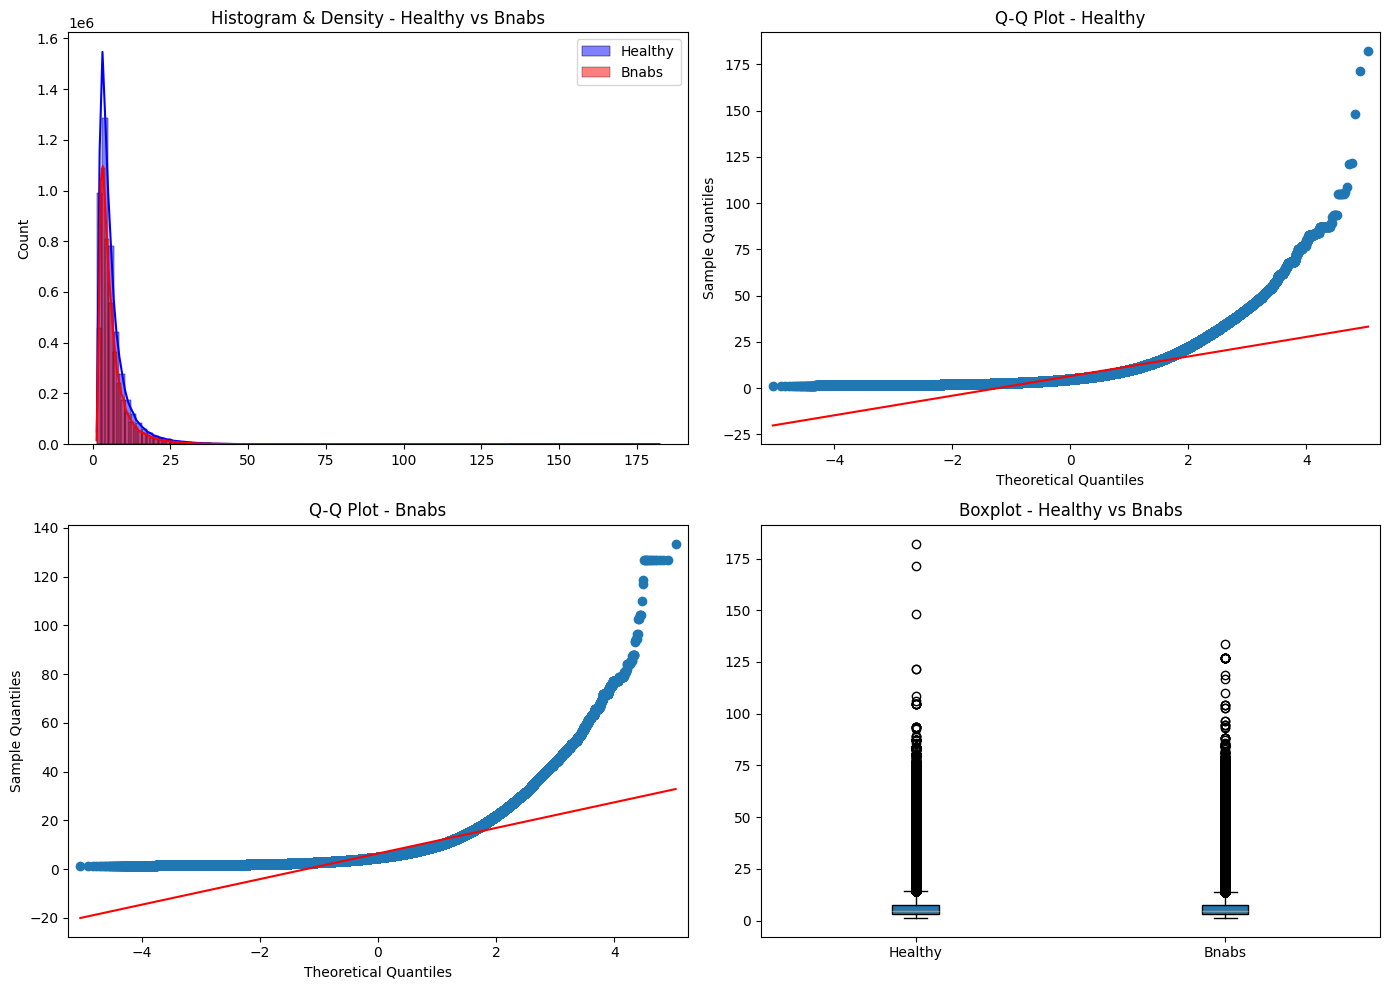

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, kstest, norm, anderson
import statsmodels.api as sm

# Supponiamo che tu abbia queste due variabili già caricate
# healthy = [[...], [...], ...]
# diseased = [[...], [...], ...]

# Flatten dei dati aggregati
healthy_flat = np.hstack(healthy)
diseased_flat = np.hstack(diseased)

print("**** Normality Tests on Aggregated Data ****")

# Shapiro-Wilk Test
stat, p = shapiro(healthy_flat[:5000])  # Limite di Shapiro per grandi N
print(f"Shapiro-Wilk Test (Healthy): p = {p:.3g}", "❌ Not normal" if p < 0.05 else "✅ Normal")
stat, p = shapiro(diseased_flat[:5000])
print(f"Shapiro-Wilk Test (Diseased): p = {p:.3g}", "❌ Not normal" if p < 0.05 else "✅ Normal")

# Kolmogorov-Smirnov Test (vs Normal)
stat, p = kstest(healthy_flat, 'norm', args=(np.mean(healthy_flat), np.std(healthy_flat)))
print(f"Kolmogorov-Smirnov (Healthy): p = {p:.3g}", "❌ Not normal" if p < 0.05 else "✅ Normal")
stat, p = kstest(diseased_flat, 'norm', args=(np.mean(diseased_flat), np.std(diseased_flat)))
print(f"Kolmogorov-Smirnov (Diseased): p = {p:.3g}", "❌ Not normal" if p < 0.05 else "✅ Normal")

# Anderson-Darling Test
result = anderson(healthy_flat, dist='norm')
print(f"Anderson-Darling (Healthy): {result.statistic:.2e} ❌ Deviates from normality")
result = anderson(diseased_flat, dist='norm')
print(f"Anderson-Darling (Diseased): {result.statistic:.2e} ❌ Deviates from normality")

print("\n**** Normality Tests for Individual Patients ****")

def check_patient_normality(patients):
    n_total = len(patients)
    n_non_normal = sum(shapiro(np.array(p)[:5000])[1] < 0.05 for p in patients)
    return n_non_normal / n_total * 100

healthy_non_normal = check_patient_normality(healthy)
diseased_non_normal = check_patient_normality(diseased)
print(f"Healthy normality: {healthy_non_normal:.2f}% non-normal ❌ Significant deviation")
print(f"Diseased normality: {diseased_non_normal:.2f}% non-normal ❌ Significant deviation")

### 📊 Plotting

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram + KDE
sns.histplot(healthy_flat, bins=100, kde=True, color='blue', stat='count', label='Healthy', ax=axes[0, 0])
sns.histplot(diseased_flat, bins=100, kde=True, color='red', stat='count', label='Bnabs', ax=axes[0, 0])
axes[0, 0].set_title("Histogram & Density - Healthy vs Bnabs")
axes[0, 0].legend()

# Q-Q Plot - Healthy
sm.qqplot(np.array(healthy_flat), line='s', ax=axes[0, 1])
axes[0, 1].set_title("Q-Q Plot - Healthy")

# Q-Q Plot - Diseased
sm.qqplot(np.array(diseased_flat), line='s', ax=axes[1, 0])
axes[1, 0].set_title("Q-Q Plot - Bnabs")

# Boxplot
data = [healthy_flat, diseased_flat]
axes[1, 1].boxplot(data, vert=True, patch_artist=True, labels=['Healthy', 'Bnabs'])
axes[1, 1].set_title("Boxplot - Healthy vs Bnabs")

plt.tight_layout()
plt.show()


# DISTANCES

### wasserstein_distance

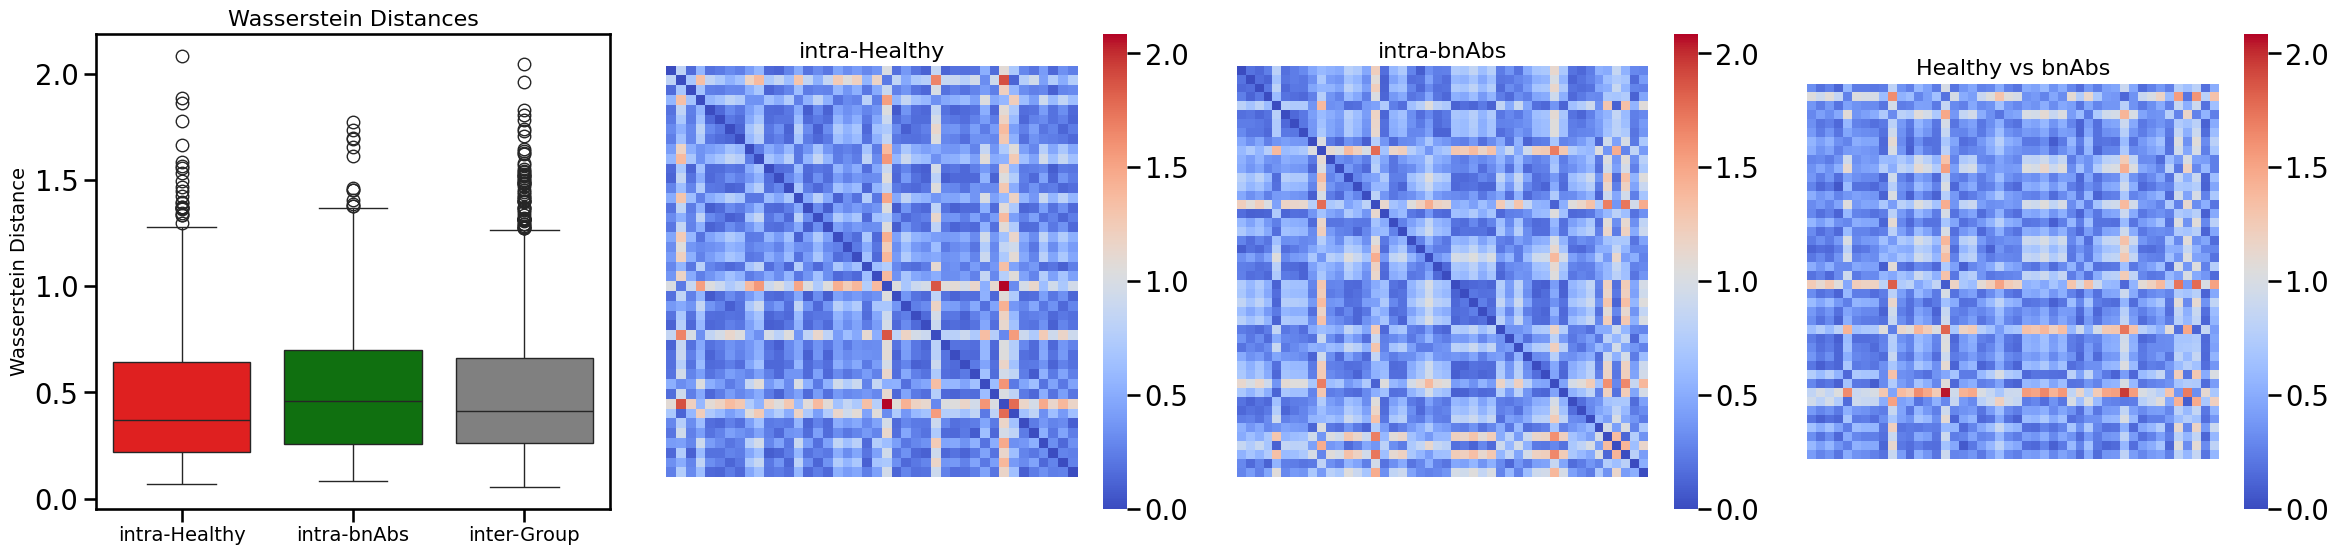

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance

# Funzioni
def compute_distance_matrix(group1, group2):
    matrix = np.zeros((len(group1), len(group2)))
    for i, p1 in enumerate(group1):
        for j, p2 in enumerate(group2):
            matrix[i, j] = wasserstein_distance(p1, p2)
    return matrix

def upper_triangle_values(matrix):
    return matrix[np.triu_indices_from(matrix, k=1)]

# Calcoli
intra_healthy = compute_distance_matrix(healthy, healthy)
intra_bnabs = compute_distance_matrix(diseased, diseased)
inter_group = compute_distance_matrix(healthy, diseased)
#all_vs_all = compute_distance_matrix(healthy + diseased, healthy + diseased)

intra_healthy_vals = upper_triangle_values(intra_healthy)
intra_bnabs_vals = upper_triangle_values(intra_bnabs)
inter_group_vals = inter_group.flatten()
#all_vs_all_vals = all_vs_all.flatten()

# Calcola min e max globali per tutte le heatmap
all_vals = np.concatenate([intra_healthy.flatten(), intra_bnabs.flatten(), inter_group.flatten()])
vmin = all_vals.min()
vmax = all_vals.max()

# 📊 Plot
sns.set_context("talk", font_scale=1.2)

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Boxplot
box_colors = ['red', 'green', 'gray']
sns.boxplot(data=[intra_healthy_vals, intra_bnabs_vals, inter_group_vals],
            palette=box_colors, ax=axes[0])
axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(['intra-Healthy', 'intra-bnAbs', 'inter-Group'], fontsize=14)
axes[0].set_ylabel("Wasserstein Distance", fontsize=14)
axes[0].set_title("Wasserstein Distances", fontsize=16)
axes[0].grid(False)

# Heatmaps con scala uniforme
sns.heatmap(intra_healthy, ax=axes[1], cmap='coolwarm', square=True, cbar=True, vmin=vmin, vmax=vmax)
axes[1].set_title("intra-Healthy", fontsize=16)

sns.heatmap(intra_bnabs, ax=axes[2], cmap='coolwarm', square=True, cbar=True, vmin=vmin, vmax=vmax)
axes[2].set_title("intra-bnAbs", fontsize=16)

sns.heatmap(inter_group, ax=axes[3], cmap='coolwarm', square=True, cbar=True, vmin=vmin, vmax=vmax)
axes[3].set_title("Healthy vs bnAbs", fontsize=16)

# Pulizia assi
for ax in axes[1:]:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


/tmp/ipykernel_3106865/175286093.py:21: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(matrix, method='average')
/tmp/ipykernel_3106865/175286093.py:26: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  row_linkage = linkage(matrix, method='average')  # cluster righe
/tmp/ipykernel_3106865/175286093.py:27: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  col_linkage = linkage(matrix.T, method='average')  # cluster colonne


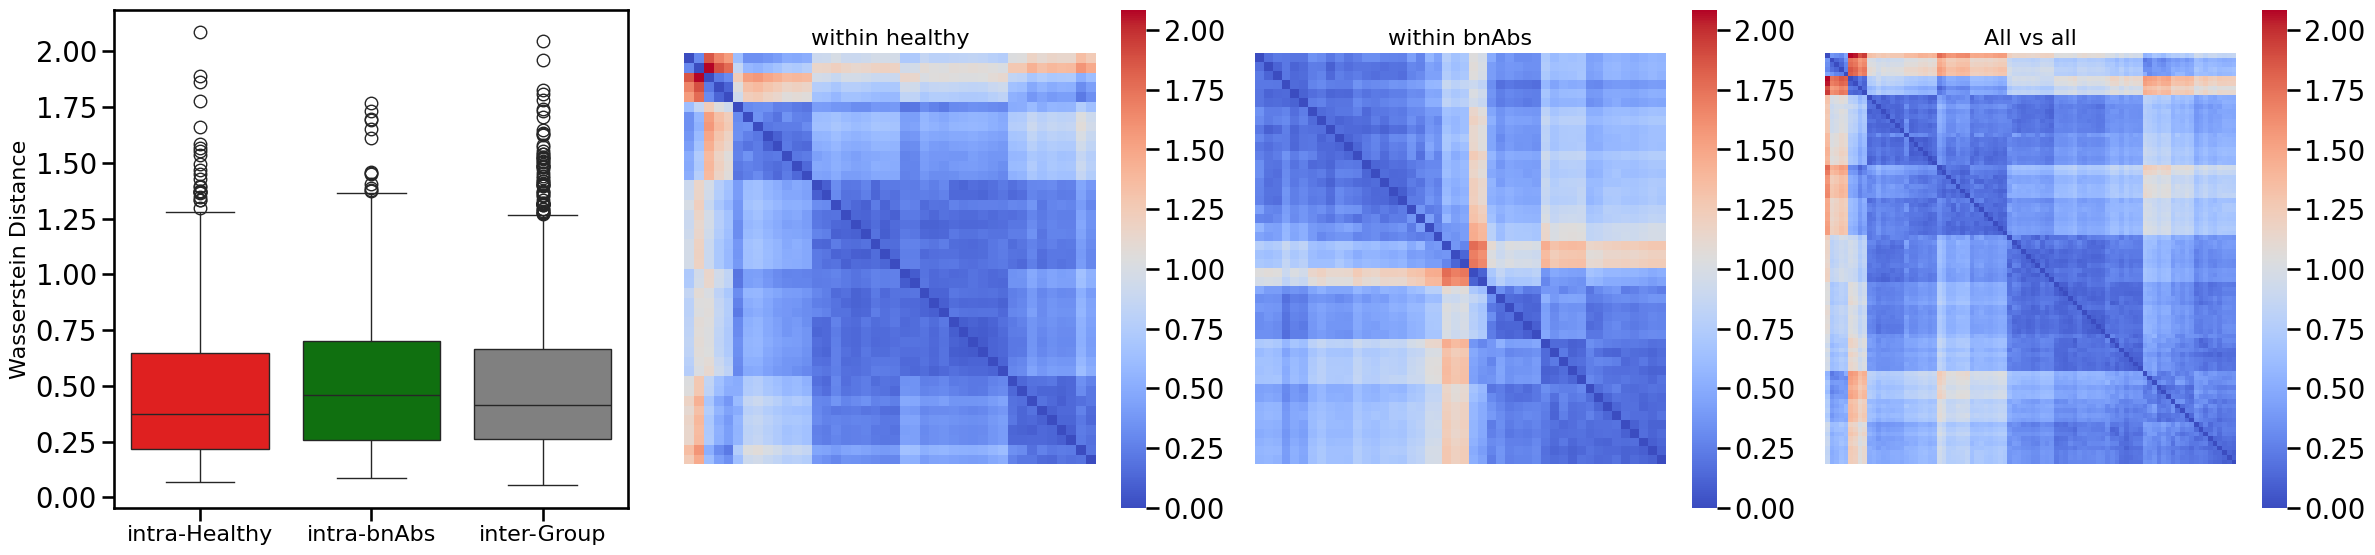

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance
from scipy.cluster.hierarchy import linkage, leaves_list

# Funzioni
def compute_distance_matrix(group1, group2):
    matrix = np.zeros((len(group1), len(group2)))
    for i, p1 in enumerate(group1):
        for j, p2 in enumerate(group2):
            matrix[i, j] = wasserstein_distance(p1, p2)
    return matrix

def upper_triangle_values(matrix):
    return matrix[np.triu_indices_from(matrix, k=1)]

def reorder_matrix(matrix):
    if matrix.shape[0] != matrix.shape[1]:
        return matrix  # inter-group: not square, skip reordering
    linkage_matrix = linkage(matrix, method='average')
    order = leaves_list(linkage_matrix)
    return matrix[np.ix_(order, order)]

def reorder_inter_group_matrix(matrix):
    row_linkage = linkage(matrix, method='average')  # cluster righe
    col_linkage = linkage(matrix.T, method='average')  # cluster colonne
    row_order = leaves_list(row_linkage)
    col_order = leaves_list(col_linkage)
    return matrix[np.ix_(row_order, col_order)]

# Calcoli
intra_healthy = compute_distance_matrix(healthy, healthy)
intra_bnabs = compute_distance_matrix(diseased, diseased)
inter_group = compute_distance_matrix(healthy, diseased)
all_vs_all = compute_distance_matrix(healthy + diseased, healthy + diseased)

intra_healthy_vals = upper_triangle_values(intra_healthy)
intra_bnabs_vals = upper_triangle_values(intra_bnabs)
inter_group_vals = inter_group.flatten()

# Calcola min e max globali per normalizzare la scala delle heatmap
all_vals = np.concatenate([intra_healthy.flatten(), intra_bnabs.flatten(), inter_group.flatten()])
vmin = all_vals.min()
vmax = all_vals.max()

# Riordino le matrici per raggruppare simili
intra_healthy_sorted = reorder_matrix(intra_healthy)
intra_bnabs_sorted = reorder_matrix(intra_bnabs)
#inter_group_sorted = reorder_inter_group_matrix(inter_group)
all_vs_all_sorted = reorder_inter_group_matrix(all_vs_all)

# 📊 Plot
sns.set_context("talk", font_scale=1.2)
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Boxplot
box_colors = ['red', 'green', 'gray']
sns.boxplot(data=[intra_healthy_vals, intra_bnabs_vals, inter_group_vals],
            palette=box_colors, ax=axes[0])
axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(['intra-Healthy', 'intra-bnAbs', 'inter-Group'], fontsize=16)
axes[0].set_ylabel("Wasserstein Distance", fontsize=16)
#axes[0].set_title("Wasserstein Distances", fontsize=16)
axes[0].grid(False)

# Heatmaps
sns.heatmap(intra_healthy_sorted, ax=axes[1], cmap='coolwarm', square=True, cbar=True, vmin=vmin, vmax=vmax)
axes[1].set_title("within healthy", fontsize=16)


sns.heatmap(intra_bnabs_sorted, ax=axes[2], cmap='coolwarm', square=True, cbar=True, vmin=vmin, vmax=vmax)
axes[2].set_title("within bnAbs", fontsize=16)

sns.heatmap(all_vs_all_sorted, ax=axes[3], cmap='coolwarm', square=True, cbar=True, vmin=vmin, vmax=vmax)
axes[3].set_title("All vs all", fontsize=16)

# Pulizia assi heatmap
for ax in axes[1:]:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


/home/rodelc/anaconda3/envs/aa_ss_tokenizer_2.0/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/rodelc/anaconda3/envs/aa_ss_tokenizer_2.0/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/rodelc/anaconda3/envs/aa_ss_tokenizer_2.0/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/rodelc/anaconda3/envs/aa_ss_tokenizer_2.0/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hol

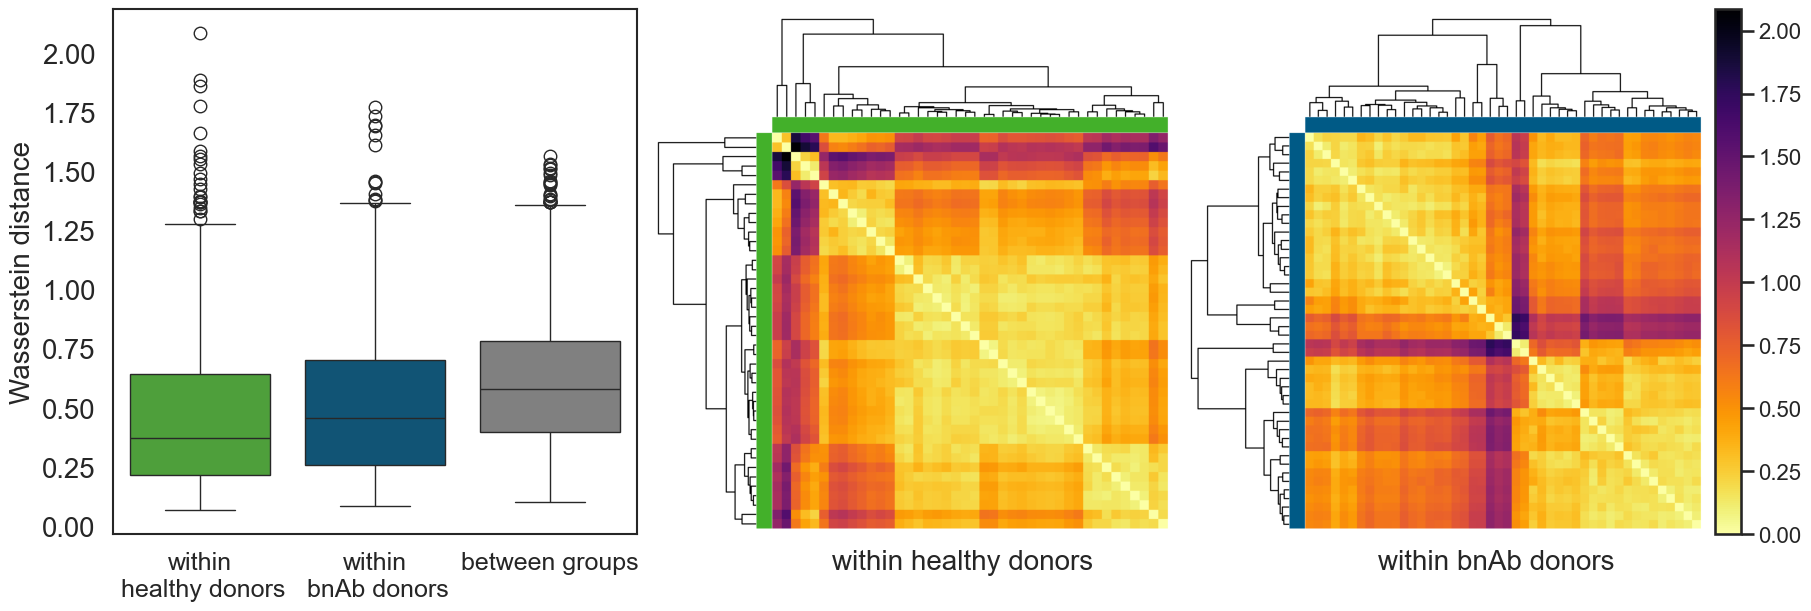

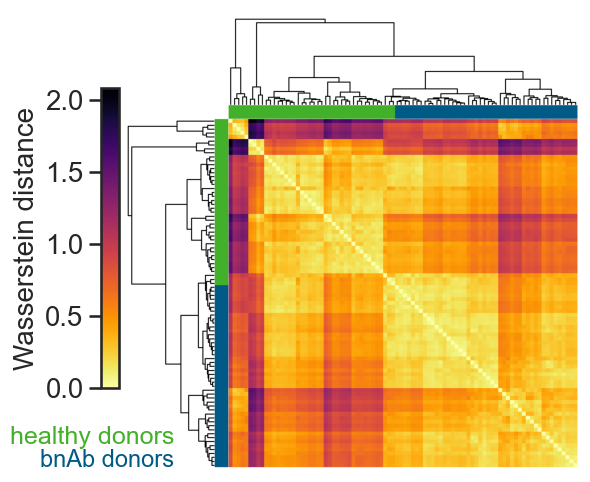

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches
n_healthy = len(healthy)
n_bnabs = len(diseased)
# Definisci i colori per ciascun gruppo
group_colors = {"Healthy": "#43B02A", "bnAbs": "#005a86ff"}
group_labels = ["Healthy"] * n_healthy + ["bnAbs"] * n_bnabs
row_colors = [group_colors[label] for label in group_labels]

# === SIMULAZIONE DATI (puoi sostituire con i tuoi veri array) ===
n_bnabs =len(diseased)
n_healthy = len(healthy)
intra_healthy_vals = intra_healthy_sorted[np.triu_indices_from(intra_healthy_sorted, k=1)]
intra_bnabs_vals = intra_bnabs_sorted[np.triu_indices_from(intra_bnabs_sorted, k=1)]
inter_group_vals = all_vs_all_sorted[:n_healthy, n_healthy:].flatten()

# === CONFIGURAZIONE ===
sns.set_style("white")
all_data = np.concatenate([
    intra_healthy_sorted.flatten(),
    intra_bnabs_sorted.flatten(),
    all_vs_all_sorted.flatten()
])
vmin, vmax = all_data.min(), all_data.max()

# === ANNOTAZIONE GRUPPI ===
group_labels = ["Healthy"] * n_healthy + ["BnAbs"] * n_bnabs
group_colors = {"Healthy": "#43B02A", "BnAbs": "#005a86ff"}
row_colors = [group_colors[label] for label in group_labels]

def clustermap_to_image(data, row_colors=None, group_colors=None):
    g = sns.clustermap(
        data,
        cmap="inferno_r",
        vmin=vmin,
        vmax=vmax,
        row_colors=row_colors,
        col_colors=row_colors,
        xticklabels=False,
        yticklabels=False
    )

    # Rimuove la colorbar generata da seaborn, se presente
    if hasattr(g, 'cax') and g.cax is not None:
        g.cax.set_visible(False)
        g.fig.delaxes(g.cax)

    # Migliora la visibilità dei dendrogrammi
    for ax in [g.ax_row_dendrogram, g.ax_col_dendrogram]:
        for child in ax.get_children():
            if hasattr(child, 'set_color') and hasattr(child, 'set_linewidth'):
                child.set_color("black")
                child.set_linewidth(1.5)

    # # Aggiungi la legenda dei gruppi
    # if group_colors is not None:
    #     for i, (label, color) in enumerate(group_colors.items()):
    #         g.ax_heatmap.text(
    #             1.02, 0.95 - i * 0.05,  # posizione
    #             label, color=color, fontsize=16,
    #             transform=g.ax_heatmap.transAxes,
    #             ha='left', va='center'
    #         )


    # Salva l'immagine in memoria
    buf = io.BytesIO()
    g.fig.savefig(buf, format='png', bbox_inches='tight', dpi=150)
    plt.close(g.fig)
    buf.seek(0)
    return Image.open(buf)


# === GENERAZIONE DELLE CLUSTERMAP ===
img1 = clustermap_to_image(intra_healthy_sorted, row_colors=[group_colors[label] for label in (["Healthy"] * n_healthy)], group_colors=group_colors)
img2 = clustermap_to_image(intra_bnabs_sorted, row_colors=[group_colors[label] for label in (["BnAbs"] * n_bnabs)], group_colors=group_colors  )
img3 = clustermap_to_image(all_vs_all_sorted, row_colors=row_colors, group_colors=group_colors)


# === FIGURA PRINCIPALE ===
fig, axs = plt.subplots(1, 4, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1, 1, 0.05]}, constrained_layout=True)

box_colors = ['#43B02A', '#005a86ff', 'gray']
sns.boxplot(data=[intra_healthy_vals, intra_bnabs_vals, inter_group_vals],
            palette=box_colors, ax=axs[0])
axs[0].set_xticks([0, 1, 2])
axs[0].set_xticklabels(["within\n healthy donors", "within\n bnAb donors", "between groups"], fontsize=14)
axs[0].set_ylabel("Wasserstein distance", fontsize=20)
axs[0].grid(False)
plt.setp(axs[0].get_xticklabels(),  fontsize=18)
for spine in axs[0].spines.values():
    spine.set_linewidth(1.5)

for ax, img in zip(axs[1:3], [img1, img2]):
    ax.imshow(img)
    ax.axis("off")

titles = ["within healthy donors", "within bnAb donors"]
for i, title in enumerate(titles):
    axs[i + 1].text(0.6, -0.03, title, transform=axs[i + 1].transAxes,
                    ha='center', va='top', fontsize=20)

norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap="inferno_r")
sm.set_array([])
fig.colorbar(sm, cax=axs[3])
axs[3].tick_params(labelsize=16)

plt.subplots_adjust(wspace=0.00)
plt.show()

# 🔸 Salvataggio della figura principale
fig.savefig("PAPER_SI_Wasserstein_boxplot_dendrogram.png", format="png", dpi=300, bbox_inches="tight")
fig.savefig("PAPER_SI_Wasserstein_boxplot_dendrogram.svg", format="svg",  dpi=300, bbox_inches="tight")

# === SINGOLO PLOT CON CLUSTERMAP "ALL VS ALL" ===
fig2, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img3)
ax.axis("off")

# ------ spazio a sinistra per color-bar ------
fig2.subplots_adjust(left=0.00,  right=0.95)   # <-- cambia se serve

# ------ color-bar a sinistra ------
cbar_ax = fig2.add_axes([0.06, 0.25, 0.03, 0.5])   # [x0, y0, width, height]
cbar     = fig2.colorbar(sm, cax=cbar_ax)

# tick + label sul lato sinistro della barra
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.yaxis.set_label_position('left')
cbar.set_label("Wasserstein distance", rotation=90, labelpad=4, fontsize=20)

# ------ legenda per i gruppi ------
ax.text(0.12, 0.1, "healthy donors", color="#43B02A", transform=ax.transAxes,
        ha='right', va='top', fontsize=18)
ax.text(0.12, 0.05, "bnAb donors",   color="#005a86ff", transform=ax.transAxes,
        ha='right', va='top', fontsize=17)

plt.show()

fig2.savefig("PAPER_Wasserstein_dendrogram_all_vs_all.png",
             dpi=300, bbox_inches="tight")
fig2.savefig("PAPER_Wasserstein_dendrogram_all_vs_all.svg",
             dpi=300, bbox_inches="tight")


#### JJ DISTANCE

/tmp/ipykernel_1726189/175286093.py:21: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(matrix, method='average')
/tmp/ipykernel_1726189/175286093.py:26: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  row_linkage = linkage(matrix, method='average')  # cluster righe
/tmp/ipykernel_1726189/175286093.py:27: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  col_linkage = linkage(matrix.T, method='average')  # cluster colonne


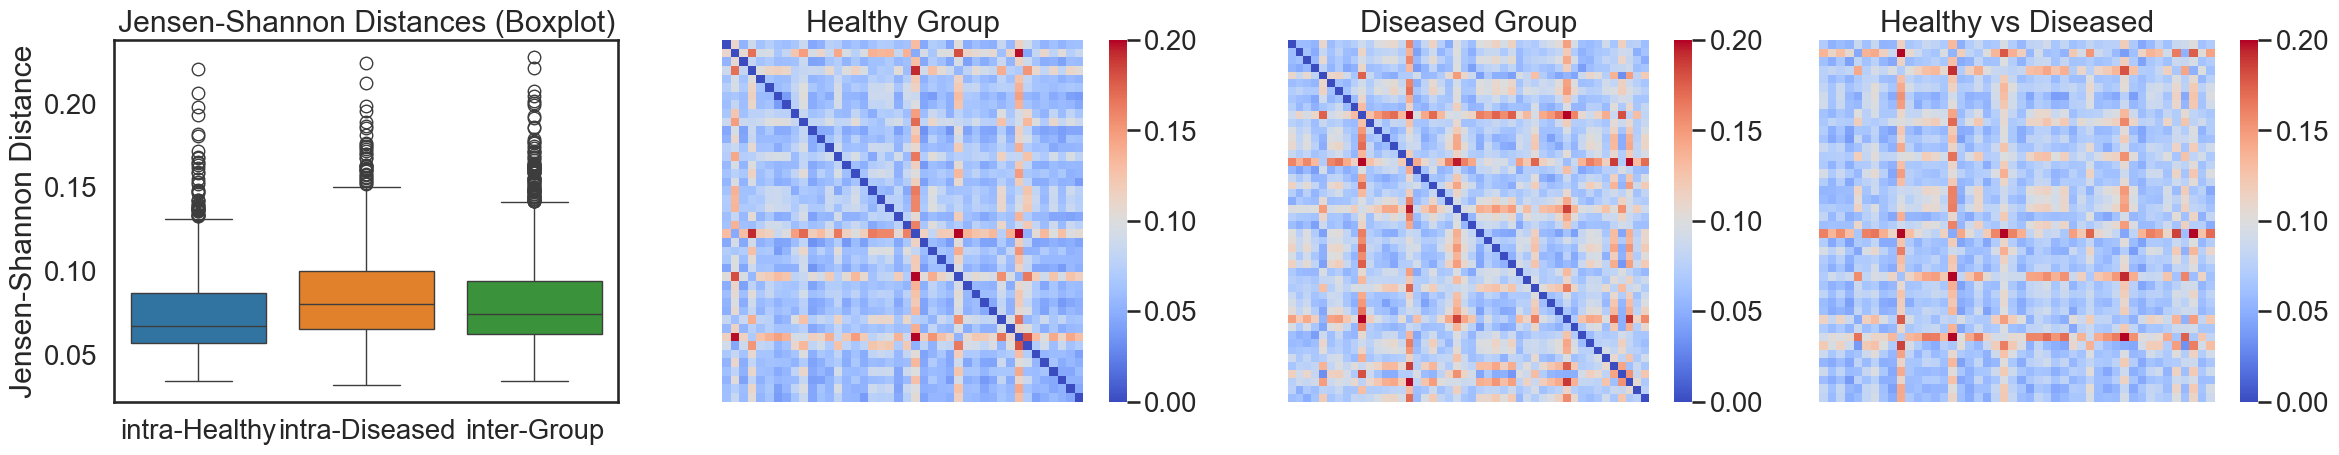

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon

# === CONFIGURAZIONE ===
n_bins = 100  # Puoi regolare questo valore in base ai tuoi dati
range_min = 0
range_max = 160  # adatta al tuo dominio

# === Binning e normalizzazione ===
def preprocess(patients, bins, range_min, range_max):
    processed = []
    for p in patients:
        hist, _ = np.histogram(p, bins=bins, range=(range_min, range_max), density=True)
        hist = hist + 1e-12  # smoothing per evitare log(0)
        hist /= np.sum(hist)
        processed.append(hist)
    return processed

# Preprocessing
healthy_proc = preprocess(healthy, n_bins, range_min, range_max)
diseased_proc = preprocess(diseased, n_bins, range_min, range_max)

# === Jensen-Shannon Matrix ===
def compute_js_matrix(group1, group2):
    matrix = np.zeros((len(group1), len(group2)))
    for i in range(len(group1)):
        for j in range(len(group2)):
            matrix[i, j] = jensenshannon(group1[i], group2[j], base=2)
    return matrix

def upper_triangle_values(matrix):
    return matrix[np.triu_indices_from(matrix, k=1)]

# Calcolo distanze
intra_healthy = compute_js_matrix(healthy_proc, healthy_proc)
intra_bnabs = compute_js_matrix(diseased_proc, diseased_proc)
inter_group = compute_js_matrix(healthy_proc, diseased_proc)
all_vs_all = compute_js_matrix(healthy_proc + diseased_proc, healthy_proc + diseased_proc)

intra_healthy_vals = upper_triangle_values(intra_healthy)
intra_bnabs_vals = upper_triangle_values(intra_bnabs)
inter_group_vals = inter_group.flatten()

##############################à

# Calcola min e max globali per normalizzare la scala delle heatmap
all_vals = np.concatenate([intra_healthy.flatten(), intra_bnabs.flatten(), inter_group.flatten()])
vmin = all_vals.min()
vmax = all_vals.max()

# Riordino le matrici per raggruppare simili
intra_healthy_sorted = reorder_matrix(intra_healthy)
intra_bnabs_sorted = reorder_matrix(intra_bnabs)
all_vs_all_sorted = reorder_inter_group_matrix(all_vs_all)

#################
# === Plot ===
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# Boxplot
sns.boxplot(data=[intra_healthy_vals, intra_bnabs_vals, inter_group_vals], ax=axes[0])
axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(['intra-Healthy', 'intra-Diseased', 'inter-Group'])
axes[0].set_ylabel("Jensen-Shannon Distance")
axes[0].set_title("Jensen-Shannon Distances (Boxplot)")
axes[0].grid(False)

# Heatmaps
sns.heatmap(intra_healthy, ax=axes[1], cmap='coolwarm', square=True, cbar=True, vmin=0, vmax=0.2)
axes[1].set_title("Healthy Group")

sns.heatmap(intra_bnabs, ax=axes[2], cmap='coolwarm', square=True, cbar=True, vmin=0, vmax=0.2)
axes[2].set_title("Diseased Group")

sns.heatmap(inter_group, ax=axes[3], cmap='coolwarm', square=True, cbar=True, vmin=0, vmax=0.2)
axes[3].set_title("Healthy vs Diseased")

for ax in axes[1:]:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


/home/rodelc/anaconda3/envs/aa_ss_tokenizer_2.0/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/rodelc/anaconda3/envs/aa_ss_tokenizer_2.0/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/rodelc/anaconda3/envs/aa_ss_tokenizer_2.0/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/rodelc/anaconda3/envs/aa_ss_tokenizer_2.0/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hol

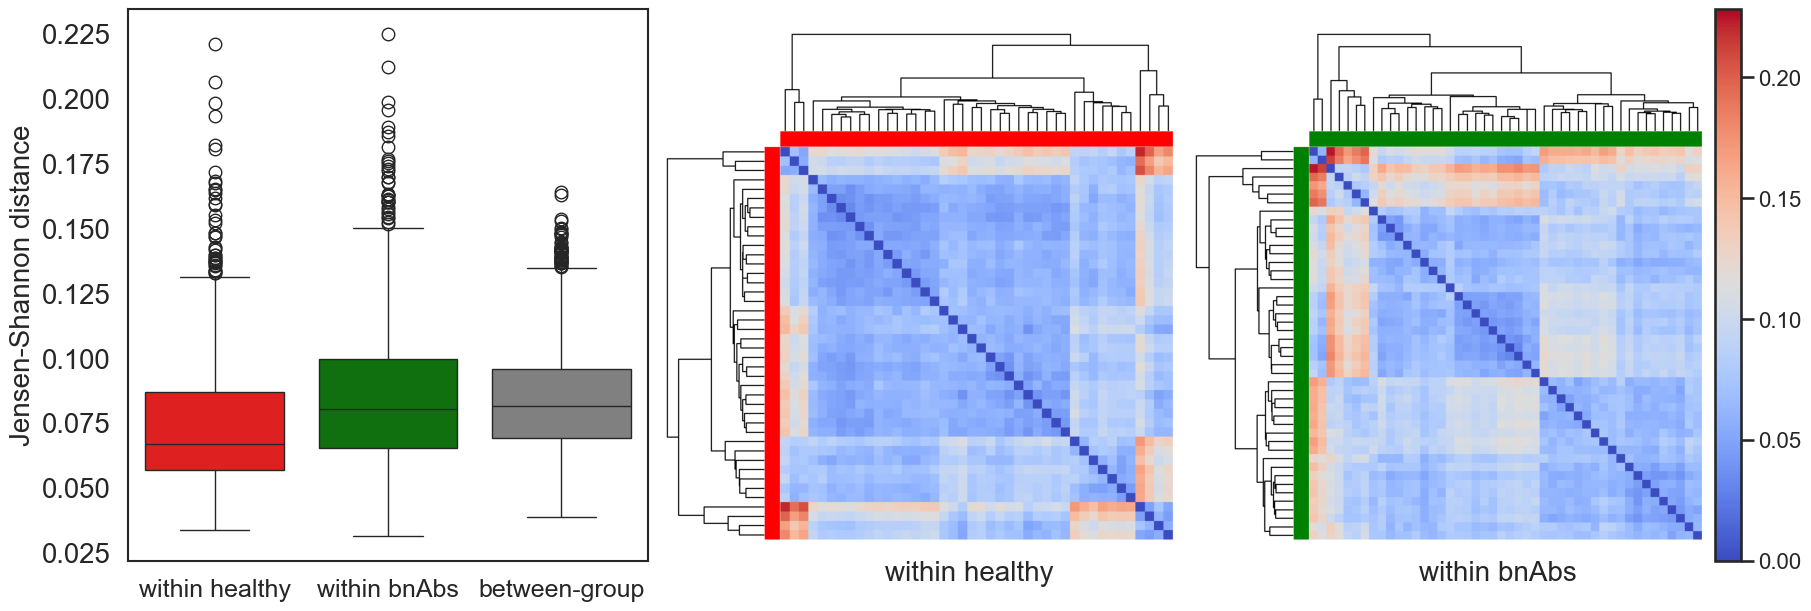

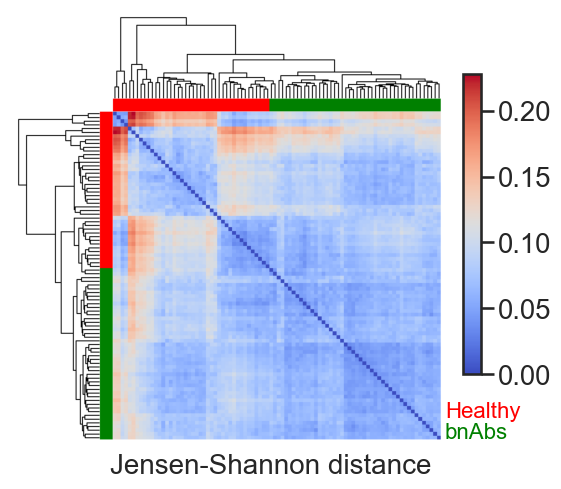

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches

# Definisci i colori per ciascun gruppo
group_colors = {"Healthy": "red", "bnAbs": "green"}
group_labels = ["Healthy"] * n_healthy + ["bnAbs"] * n_bnabs
row_colors = [group_colors[label] for label in group_labels]

# === SIMULAZIONE DATI (puoi sostituire con i tuoi veri array) ===
n_bnabs =len(diseased)
n_healthy = len(healthy)
intra_healthy_vals = intra_healthy_sorted[np.triu_indices_from(intra_healthy_sorted, k=1)]
intra_bnabs_vals = intra_bnabs_sorted[np.triu_indices_from(intra_bnabs_sorted, k=1)]
inter_group_vals = all_vs_all_sorted[:n_healthy, n_healthy:].flatten()

# === CONFIGURAZIONE ===
sns.set_style("white")
all_data = np.concatenate([
    intra_healthy_sorted.flatten(),
    intra_bnabs_sorted.flatten(),
    all_vs_all_sorted.flatten()
])
vmin, vmax = all_data.min(), all_data.max()

# === ANNOTAZIONE GRUPPI ===
group_labels = ["Healthy"] * n_healthy + ["BnAbs"] * n_bnabs
group_colors = {"Healthy": "red", "BnAbs": "green"}
row_colors = [group_colors[label] for label in group_labels]

def clustermap_to_image(data, row_colors=None, group_colors=None):
    g = sns.clustermap(
        data,
        cmap="coolwarm",
        vmin=vmin,
        vmax=vmax,
        row_colors=row_colors,
        col_colors=row_colors,
        xticklabels=False,
        yticklabels=False
    )

    # Rimuove la colorbar generata da seaborn, se presente
    if hasattr(g, 'cax') and g.cax is not None:
        g.cax.set_visible(False)
        g.fig.delaxes(g.cax)

    # Migliora la visibilità dei dendrogrammi
    for ax in [g.ax_row_dendrogram, g.ax_col_dendrogram]:
        for child in ax.get_children():
            if hasattr(child, 'set_color') and hasattr(child, 'set_linewidth'):
                child.set_color("black")
                child.set_linewidth(1.5)

    # # Aggiungi la legenda dei gruppi
    # if group_colors is not None:
    #     for i, (label, color) in enumerate(group_colors.items()):
    #         g.ax_heatmap.text(
    #             1.02, 0.95 - i * 0.05,  # posizione
    #             label, color=color, fontsize=16,
    #             transform=g.ax_heatmap.transAxes,
    #             ha='left', va='center'
    #         )


    # Salva l'immagine in memoria
    buf = io.BytesIO()
    g.fig.savefig(buf, format='png', bbox_inches='tight', dpi=150)
    plt.close(g.fig)
    buf.seek(0)
    return Image.open(buf)


# === GENERAZIONE DELLE CLUSTERMAP ===
img1 = clustermap_to_image(intra_healthy_sorted, row_colors=[group_colors[label] for label in (["Healthy"] * n_healthy)], group_colors=group_colors)
img2 = clustermap_to_image(intra_bnabs_sorted, row_colors=[group_colors[label] for label in (["BnAbs"] * n_bnabs)], group_colors=group_colors  )
img3 = clustermap_to_image(all_vs_all_sorted, row_colors=row_colors, group_colors=group_colors)


# === FIGURA PRINCIPALE ===
fig, axs = plt.subplots(1, 4, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1, 1, 0.05]}, constrained_layout=True)

box_colors = ['red', 'green', 'gray']
sns.boxplot(data=[intra_healthy_vals, intra_bnabs_vals, inter_group_vals],
            palette=box_colors, ax=axs[0])
axs[0].set_xticks([0, 1, 2])
axs[0].set_xticklabels(["within healthy", "within bnAbs", "between-group"], fontsize=18)
axs[0].set_ylabel("Jensen-Shannon distance", fontsize=20)
axs[0].grid(False)
for spine in axs[0].spines.values():
    spine.set_linewidth(1.5)

for ax, img in zip(axs[1:3], [img1, img2]):
    ax.imshow(img)
    ax.axis("off")

titles = ["within healthy", "within bnAbs"]
for i, title in enumerate(titles):
    axs[i + 1].text(0.6, -0.03, title, transform=axs[i + 1].transAxes,
                    ha='center', va='top', fontsize=20)

norm = Normalize(vmin=vmin, vmax=vmax)
sm = ScalarMappable(norm=norm, cmap="coolwarm")
sm.set_array([])
fig.colorbar(sm, cax=axs[3])
axs[3].tick_params(labelsize=16)

plt.subplots_adjust(wspace=0.00)
plt.show()
fig.savefig("PAPER_Jensen-Shannon_boxplot_dendrogram.png", format="png", dpi=300, bbox_inches="tight")
fig.savefig("PAPER_Jensen-Shannon_boxplot_dendrogram.svg", format="svg", bbox_inches="tight")

# === SINGOLO PLOT CON CLUSTERMAP "ALL VS ALL" ===
fig2, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img3)
ax.axis("off")
#ax.text(-0.05, 0.5, "Wasserstein Distance", transform=ax.transAxes,
#        ha='center', va='center', rotation=90, fontsize=20)
ax.text(0.6, -0.02, "Jensen-Shannon distance", transform=ax.transAxes,
        ha='center', va='top', fontsize=20)
# Legenda testo colorato accanto
ax.text(1., 0.1, "Healthy", color="red", transform=ax.transAxes,
        ha='left', va='top', fontsize=16)
ax.text(1., 0.05, "bnAbs", color="green", transform=ax.transAxes,
        ha='left', va='top', fontsize=16)


fig2.subplots_adjust(right=0.85)
cbar_ax = fig2.add_axes([0.88, 0.25, 0.03, 0.5])
fig2.colorbar(sm, cax=cbar_ax)
plt.show()


fig2.savefig("PAPER_Jensen-Shannon_dendrogram_all_vs_all.png", format="png", dpi=300, bbox_inches="tight")
fig2.savefig("PAPER_Jensen-Shannon_dendrogram_all_vs_all.svg", format="svg", bbox_inches="tight")


# TAILS ANALYSIS

In [15]:
def safe_flatten(data):
    flat = []
    for i, sample in enumerate(data):
        try:
            sample = np.asarray(sample, dtype=float)
            flat.extend(sample)
        except:
            print(f"❌ Errore nel paziente {i}, saltato.")
    return np.array(flat)

healthy_flat = safe_flatten(healthy)
diseased_flat = safe_flatten(diseased)

In [16]:
# Percentili
q5_healthy, q95_healthy = np.percentile(healthy_flat, [5, 95])
q5_diseased, q95_diseased = np.percentile(diseased_flat, [5, 95])
print(f"5th-95th Percentiles - Healthy: [{q5_healthy:.8f} {q95_healthy:.8f}], Diseased: [{q5_diseased:.8f} {q95_diseased:.8f}]")

# Code
upper_tail_healthy = healthy_flat[healthy_flat > q95_healthy]
upper_tail_diseased = diseased_flat[diseased_flat > q95_diseased]
lower_tail_healthy = healthy_flat[healthy_flat < q5_healthy]
lower_tail_diseased = diseased_flat[diseased_flat < q5_diseased]

# Test statistici
from scipy.stats import ks_2samp, mannwhitneyu
ks_upper = ks_2samp(upper_tail_healthy, upper_tail_diseased)
ks_lowerks_2samp = ks_2samp(lower_tail_healthy, lower_tail_diseased)
print(f"KS Test (Upper Tail): stat={ks_upper.statistic:.3f}, p={ks_upper.pvalue:.1g}")
print(f"KS Test (Lower Tail): stat={ks_lower.statistic:.3f}, p={ks_lower.pvalue:.1g}")

mw_upper = mannwhitneyu(upper_tail_healthy, upper_tail_diseased, alternative='two-sided')
mw_lower = mannwhitneyu(lower_tail_healthy, lower_tail_diseased, alternative='two-sided')
print(f"Mann-Whitney U Test (Upper Tail): stat={mw_upper.statistic:.3f}, p={mw_upper.pvalue:.1g}")
print(f"Mann-Whitney U Test (Lower Tail): stat={mw_lower.statistic:.3f}, p={mw_lower.pvalue:.1g}")

# IQR
def compute_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    return q3 - q1

iqr_h = compute_iqr(healthy_flat)
iqr_d = compute_iqr(diseased_flat)
print(f"IQR - Healthy: {iqr_h:.3f}, Diseased: {iqr_d:.3f}")


5th-95th Percentiles - Healthy: [2.22119284 16.61820030], Diseased: [2.23732305 16.41311016]
KS Test (Upper Tail): stat=0.030, p=2e-87


NameError: name 'ks_lower' is not defined